# MONAI Auto3Dseg "Hello World" Example

このノートブックでは、Auto3Dseg AutoRunnerを使って、シミュレーションされたデータセットを処理し、数分で結果を生成する方法を簡単に説明します。

## 1. 環境、import、datasetのセットアップ

### 1.1 環境のセットアップ

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [2]:
# 上記では足りないモジュールがあるため、すべてインストール
# 参照：https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies
!pip install -q 'monai[all]'

     |████████████████████████████████| 1.1 MB 4.7 MB/s 
     |████████████████████████████████| 264 kB 66.2 MB/s 
     |████████████████████████████████| 8.6 MB 50.9 MB/s 
     |████████████████████████████████| 125 kB 55.8 MB/s 
     |████████████████████████████████| 16.9 MB 35.6 MB/s 
     |████████████████████████████████| 348 kB 45.3 MB/s 
     |████████████████████████████████| 4.7 MB 42.8 MB/s 
     |████████████████████████████████| 87 kB 3.3 MB/s 
     |████████████████████████████████| 31.0 MB 1.6 MB/s 
     |████████████████████████████████| 56.0 MB 12 kB/s 
     |████████████████████████████████| 2.0 MB 48.9 MB/s 
     |████████████████████████████████| 316 kB 51.2 MB/s 
     |████████████████████████████████| 54.5 MB 53 kB/s 
     |████████████████████████████████| 16.6 MB 43.5 MB/s 
     |████████████████████████████████| 95.3 MB 1.2 MB/s 
     |████████████████████████████████| 20.3 MB 1.1 MB/s 
     |████████████████████████████████| 15.0 MB 51.4 MB/s 
     |██████████

### 1.2 importのセットアップ

In [3]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.apps.auto3dseg import AutoRunner
from monai.data import create_test_image_3d

### 1.3 特殊なデータセットをシミュレートする

AIの学習には時間がかかることはよく知られています。このノートでは、Auto3Dの「Hello World！」な体験を提供するために、小さなデータセットをシミュレートし、複数のエポックに対してのみ学習を実行することにします。AIの性質上、性能はあまり期待できませんが、パイプライン全体は数分以内に完了する予定です

`sim_datalist` は、シミュレーションしたデータセットの情報を提供します。12枚のトレーニング画像と2枚のテスト画像とラベルがリストアップされています。トレーニングデータは3つのフォールドに分割されています。各フォールドでは、8枚の画像をトレーニングに、4枚の画像を検証に使用します。次元の大きさは  `sim_dim`  で定義されます．

In [4]:
sim_datalist = {
    "testing": [
        {"image": "test_image_001.nii.gz", "label": "test_label_001.nii.gz"},
        {"image": "test_image_002.nii.gz", "label": "test_label_002.nii.gz"},
    ],
    "training": [
        {"fold": 0, "image": "tr_image_001.nii.gz", "label": "tr_label_001.nii.gz"},
        {"fold": 0, "image": "tr_image_002.nii.gz", "label": "tr_label_002.nii.gz"},
        {"fold": 0, "image": "tr_image_003.nii.gz", "label": "tr_label_003.nii.gz"},
        {"fold": 0, "image": "tr_image_004.nii.gz", "label": "tr_label_004.nii.gz"},
        {"fold": 1, "image": "tr_image_005.nii.gz", "label": "tr_label_005.nii.gz"},
        {"fold": 1, "image": "tr_image_006.nii.gz", "label": "tr_label_006.nii.gz"},
        {"fold": 1, "image": "tr_image_007.nii.gz", "label": "tr_label_007.nii.gz"},
        {"fold": 1, "image": "tr_image_008.nii.gz", "label": "tr_label_008.nii.gz"},
        {"fold": 2, "image": "tr_image_009.nii.gz", "label": "tr_label_009.nii.gz"},
        {"fold": 2, "image": "tr_image_010.nii.gz", "label": "tr_label_010.nii.gz"},
        {"fold": 2, "image": "tr_image_011.nii.gz", "label": "tr_label_011.nii.gz"},
        {"fold": 2, "image": "tr_image_012.nii.gz", "label": "tr_label_012.nii.gz"},
    ],
}

sim_dim = (64, 64, 64)

### 1.4 画像とラベルの生成

MONAI `create_test_image_3d` と `nib.Nifti1Image` 関数を使って、work_dir の下に3Dシミュレーション画像を作成します。

In [5]:
work_dir = "./auto3dseg_work_dir"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, 'w') as f:
    json.dump(sim_datalist, f)

for d in sim_datalist["testing"] + sim_datalist["training"]:
    # create_test_image_3関数：ノイズの多い3D画像とセグメンテーションを作成する関数
    # create_test_image_3関数で画像とセグメンテーションを作成し、sim_datalistで指定した名称でNIfTI形式で保存する
    im, seg = create_test_image_3d(
        sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=1, random_state=np.random.RandomState(42)
    )
    image_fpath = os.path.join(dataroot_dir, d["image"])
    label_fpath = os.path.join(dataroot_dir, d["label"])
    nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)
    nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), label_fpath)

### 1.5 シミュレーションデータの確認

ここでは、シミュレーションのイメージをつかむために、テストデータセットの3D画像のスライスをピックアップしてみました。

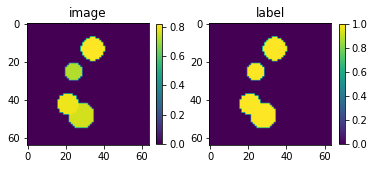

In [6]:
img_nib = nib.load(os.path.join(dataroot_dir, sim_datalist['testing'][0]['image']))
lbl_nib = nib.load(os.path.join(dataroot_dir, sim_datalist['testing'][0]['label']))
img = np.array(img_nib.dataobj)
lbl = np.array(lbl_nib.dataobj)
plt.subplot(1, 2, 1)
plt.imshow(img[32])
plt.title('image')
cbar = plt.colorbar(shrink=0.55)
plt.subplot(1, 2, 2)
plt.imshow(lbl[32])
plt.title('label')
cbar = plt.colorbar(shrink=0.55)


## 2. Auto3DsegのAutoRunnerパイプラインをテストする

AutoRunnerはAuot3Dssegパイプラインを実行するためのインターフェイスを提供します。4種類のニューラルネットワークを自動的に設定し、複数回の学習を行い、最先端の性能を実現します。このモジュールは高度な設定が可能ですが、必要なのは最小限のユーザーインプットのみです。この例では、2分でパイラインを完成させたいので、いくつかのカスタマイズが必要です

### 2.1 デフォルト設定でのAutoRunnerのセットアップ

In [7]:
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    },
    output_dir=f"{work_dir}/output",# output_dirを指定する。指定しなかった場合、出力結果を格納するensemble_outputフォルダが自動で生成される。
)

# runner.run() # この場合、デフォルトの設定が使用され、実行に数時間かかります。 

2022-09-27 13:34:39,818 - INFO - Work directory ./auto3dseg_work_dir is used to save all results
2022-09-27 13:34:39,826 - INFO - Directory ./auto3dseg_work_dir/output is created to save ensemble predictions


### 2.2 数分でパイプラインを完成させるために、学習パラメータをオーバーライドする

In [8]:
max_epochs = 2

# max_epochs が 2 以上であることを保証するためのセーフガード
max_epochs = max(max_epochs, 2)

train_param = {
    "CUDA_VISIBLE_DEVICES": [0],  # use only 1 gpu
    "num_iterations": 4 * max_epochs,
    "num_iterations_per_validation": 2 * max_epochs,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_iterations": 2 * max_epochs,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

### 2.3 データアナリシス、アルゴリズム生成、トレーニング、モデルアンサンブルの開始

In [9]:
runner.run()

100%|██████████| 12/12 [00:16<00:00,  1.33s/it]
algo_templates.tar.gz: 100%|██████████| 280k/280k [00:00<00:00, 754kB/s]  

2022-09-27 13:34:56,449 - INFO - Downloaded: /tmp/tmp0vqwygv8/algo_templates.tar.gz
2022-09-27 13:34:56,452 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp0vqwygv8/algo_templates.tar.gz.
2022-09-27 13:34:56,458 - INFO - Writing into directory: /content/auto3dseg_work_dir.


2022-09-27 13:34:56,795 - INFO - /content/auto3dseg_work_dir/segresnet2d_0
2022-09-27 13:34:57,041 - INFO - /content/auto3dseg_work_dir/dints_0
2022-09-27 13:34:57,276 - INFO - /content/auto3dseg_work_dir/swinunetr_0
2022-09-27 13:34:57,702 - INFO - /content/auto3dseg_work_dir/segresnet_0
2022-09-27 13:34:57,715 - INFO - Launching: python /content/auto3dseg_work_dir/swinunetr_0/scripts/train.py run --config_file='/content/auto3dseg_work_dir/swinunetr_0/configs/hyper_parameters.yaml','/content/auto3dseg_work_dir/swinunetr_0/configs/network.yaml','/content/auto3dseg_work_dir/swinunetr_0/configs/transforms_train.yaml','/content/auto3dseg_work_dir/swinunetr_0/configs/transforms_infer.yaml','/content/auto3dseg_work_dir/swinunetr_0/configs/transforms_validate.yaml' --num_iterations=8 --num_iterations_per_validation=4 --num_images_per_batch=2 --num_epochs=2 --num_warmup_iterations=4
2022-09-27 13:35:27,721 - INFO - CompletedProcess(args=['python', '/content/auto3dseg_work_dir/swinunetr_0/scri

### 2.4 algoでのアンサンブル予測値を確認し、正解データと比較する。

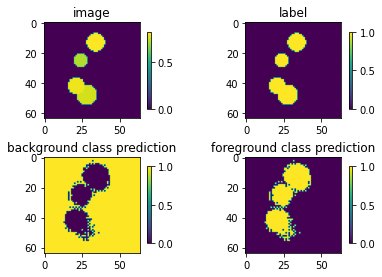

In [10]:
image_name = sim_datalist['testing'][0]['image'].split(".")[0]
prediction_nib = nib.load(os.path.join(work_dir, 'output', image_name, image_name+"_ensemble"+".nii.gz"))
pred = np.array(prediction_nib.dataobj)

plt.subplot(2, 2, 1)
plt.imshow(img[32])
plt.title('image')
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 2)
plt.imshow(lbl[32])
plt.title('label')
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 3)
plt.imshow(pred[32, :, :, 0])
plt.title('background class prediction')
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 4)
plt.imshow(pred[32, :, :, 1])
plt.title('foreground class prediction')
cbar = plt.colorbar(shrink=0.8)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

## 3. まとめ

ここで、パイプライン全体が完成しました。お気づきのように、アルゴリズムがデータセットと背景および前景voxelの予測の学習を開始するのがわかります。Auto3DsegとAutoRunnerは高度に設定可能です。より良い結果を得るために、AutoRunnerやAuto3DsegモジュールのAPIを通じて、学習時間を増やしたり、異なるアンサンブル方法を適用したり、ハイパーパラメータ最適化を使用したりすることができます。

「Hello World」ノートブックとして、ここでシミュレーションデータセットによる実験を終了します。

<br>
※voxel：体積の要素であり、3次元空間での正規格子単位の値(-1~1)を表す。